# Replicate Bresnahan and Reiss 1991

In this notebook, we will be replicating a classic paper from Industrial Organization: Bresnahan and Reiss (1991) "Entry and Competition in Concentrated Markets." The paper can be downloaded here: http://people.hss.caltech.edu/~mshum/gradio/papers/bresreiss_jpe.pdf

The data is available on the class GitHub page.

## Introduction

The abstract of the paper is this:

> This paper proposes an empirical framework for measuring the effects of entry in concentrated markets. Building on models of entry in atomistically competitive markets, we show how the number of producers in an oligopolistic market varies with changes in demand and market competition. These analytical results structure our empirical analysis of competition in five retail and professional industries. Using data on geographically isolated monopolies, duopolies, and oligopolies, we study the relationship between the number of firms in a market, market size, and competition. Our empirical results suggest that competitive conduct changes quickly as the number of incumbents increases. In markets with five or fewer incumbents, almost all variation in competitive conduct occurs with the entry of the second or third firm. Surprisingly, once the market has between three and five firms, the next entrant has little effect on competitive conduct.


## Description of the Data

For a description of the data, see Table 3 of the paper and its accompanying description.

Each observation is a "market." These are combinations of towns and industries, e.g. the tire dealer market in town "A". From p. 985,

> Our sample contains 202 isolated local markets. A typical market
in our sample is a county seat in the western United States. These county seats are separated from other towns in the county. Because most of the local population resides in or near the central town, its population provides a reasonable first approximation to $S(Y)$. 
>
> ...
>
> We selected our sample of markets and industries using criteria developed in our earlier work (see Bresnahan and Reiss 1988, 1990). Briefly, we located towns or small cities in the continental United States that were at least 20 miles from the nearest town of 1,000 people or more. We elimi- nated towns that were near large metropolitan areas or were part of a cluster of towns. Our specific criteria exclude, for example, towns within 100 miles of a city of 100,000. We believe, a priori, that these selection criteria ensure that we can identify all relevant competitors.
>
> ...
> 
> We limited our study to industries or occupations in which we could identify all sellers of a narrowly defined product or service. We did not consider grocery and clothing stores, for example, because they sell a range of products.

The data included on the GitHub repo has 202 rows, including the following variables:

  - `ID`: The unique ID associated with the represented market.
  - `TIRE`: The number of incumbent "tire dealer" firms in the market
  - `TPOP`: Town population.
  - `NGRW`: Negative TPOP growth. This represents the negative growth in town population from 1970 to 1980. 
  - `PGRW`: Positive TPOP growth. Similar to `NGRW`. These growth terms capture entrants' asymmetric expectations about future market growth as well as lags in responses to past growth.
  - `OCTY`: Commuters out of the city. There are commuters out of the county. It represents the Census Bureau's count of county residents who commute to work outside the county. (A negative calue of the coefficient $\lambda_4$ suggest that commuters purchase good in nearby markets.)
  - `OPOP`: Nearby Population. This includes population within 10 miles of the town. (This would increase demand.)
  - `LANDV`: Value per acre of farm-land and buildings  (\$1,000s)
  - `ELD`: 65 years and older divided by the county population
  - `FFRAC`: Fraction of land in farms
  - `PINC`: Per capital income (\$1,000's)
  - `LNHDD`: Log of heating degree days

Note: You can find additional variables used in the paper and their descriptions, along with summary statistics, in Table 2 on p. 991.

In [277]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [80]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [13]:
filename = 'BresnahanAndReiss1991_DATA.csv'
df = pd.read_csv(filename)

In [14]:
#Z = np.c_[df.ELD, df.PINC, df.LNHDD, df.FFRAC]

In [5]:
df.dtypes

ID         int64
TIRE       int64
TPOP     float64
NGRW     float64
PGRW     float64
OCTY     float64
OPOP     float64
LANDV    float64
ELD      float64
FFRAC    float64
PINC     float64
LNHDD    float64
dtype: object

**Figure 2**

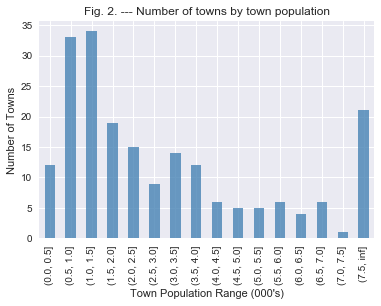

In [6]:
a = pd.cut(df.TPOP, np.r_[np.linspace(0,7.5, 16), [np.inf]])
a = a.value_counts().sort_index()
a.plot.bar(color='steelblue', alpha=.8)
plt.ylabel('Number of Towns')
plt.xlabel("Town Population Range (000's)")
plt.title('Fig. 2. --- Number of towns by town population');

**Table 2**

Market counts by industry and number of incumbents (shown for tire dealers only)

In [7]:
bins = [-np.inf, *range(1,8), np.inf]
tire_bins = pd.cut(df.TIRE, bins, right=False)
counts = tire_bins.value_counts().sort_index()
pd.DataFrame(counts).T

,"[-inf, 1.0)","[1.0, 2.0)","[2.0, 3.0)","[3.0, 4.0)","[4.0, 5.0)","[5.0, 6.0)","[6.0, 7.0)","[7.0, inf)"
TIRE,45,39,39,24,13,15,6,21


**Table 3**

Again, this replication only contains some of the variables used.

In [8]:
df.drop(['ID'], axis=1).aggregate(['mean', 'std', 'min', 'max']).T

,mean,std,min,max
TIRE,2.62,2.63,0.00,13.00
TPOP,3.74,5.35,0.12,45.09
NGRW,-0.06,0.14,-1.34,0.00
PGRW,0.49,1.05,0.00,7.23
OCTY,0.32,0.69,0.00,8.39
OPOP,0.41,0.74,0.01,5.84
LANDV,0.29,0.23,0.07,1.64
ELD,0.13,0.05,0.03,0.30
FFRAC,0.67,0.35,0.00,1.27
PINC,5.91,1.13,3.16,10.50


In [9]:
df.drop(['ID'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
TIRE,202.00,2.62,2.63,0.00,1.00,2.00,4.00,13.00
TPOP,202.00,3.74,5.35,0.12,1.05,2.10,4.34,45.09
NGRW,202.00,-0.06,0.14,-1.34,-0.04,0.00,0.00,0.00
PGRW,202.00,0.49,1.05,0.00,0.00,0.08,0.42,7.23
OCTY,202.00,0.32,0.69,0.00,0.08,0.16,0.32,8.39
OPOP,202.00,0.41,0.74,0.01,0.06,0.14,0.42,5.84
LANDV,202.00,0.29,0.23,0.07,0.14,0.24,0.35,1.64
ELD,202.00,0.13,0.05,0.03,0.10,0.13,0.16,0.30
FFRAC,202.00,0.67,0.35,0.00,0.32,0.83,0.94,1.27
PINC,202.00,5.91,1.13,3.16,5.17,5.87,6.68,10.50


## Model Description

Following the structure of equation (4), we assume that 

$$
\Pi_N = \bar \Pi_N + \epsilon = S(Y, \lambda) V_N(Z, W, \alpha, \beta) - F_N(W, \gamma) + \epsilon, \tag{8}
$$

where $\lambda$, $\alpha$, $\beta$, and $\gamma$ represent profit function parameters, $Y$ describes market size, $Z$ and $W$ shift per capita demand and costs, and the unobserved error term $\epsilon$ summarizes profits that we do not observer. To simplify the estimation procedure, we assume that $\epsilon$ has a standard normal distribution that is independently distributed across markets and is independent of our observables ($\epsilon \sim \mathcal N(0,1)$). We also assume that $\epsilon$ has zero mean and a constant variance and that each firm within a market has the same profit error. This last assumption presumes that successive entrants' profits differ only through the determinist variables in (8). Notice that we use $\hat \Pi_N$ to represent this deterministic portion of profits.


Now, how do we calculate the likelihood function of this model? Notice that since we don't observe $\Pi$, we won't be able to calculate residuals to plug into our MLE procedure. In the case of estimating a linear regression equation with MLE, we calculated residuals and plugged those residuals into a PDF. In our case, we can't do that. Instead, we can only use our data to *put bounds on epsilon*. Consider what is implied when we observe no firms in a market. If there are no firms, then this implies that the per-firm profits of one firm would be less than zero, $\Pi_1 < 0$. Let's use a little algebra to see what this implies about epsilon:

\begin{gather*}
\Pi_1 < 0 \\
\Pi_1 = \bar \Pi_1 + \epsilon < 0 \\
\epsilon < -\bar \Pi_1 
\end{gather*}

Now that we see what this implies about epsilon, since we have assumed a distribution for epsilon, we can calculate what the probability (likelihood) of this occuring. The probability of observing markets with no firms equals

\begin{align*}
P(\Pi_1 < 0) &=  P(\epsilon < -\bar \Pi_1 ) \\
  &= \Phi(-\bar \Pi_1) \\
  &= 1 - \Phi(\bar \Pi_1)
\end{align*}

where $\Phi(\cdot)$ is the cumulative normal distribution function, and $\Pi_1 = \bar \Pi_1 + \epsilon$ equals a monopolist's profits. 

If $\bar \Pi_1 \geq \bar \Pi_2 \geq ... \geq \bar \Pi_5$, the probability of observing $N$ firms in equilibrium ( $N = 1,2,3, \text{ or } 4$ ) equals

$$
P(\Pi_N \geq 0 \text{ and } \Pi_{N+1} < 0) = \Phi(\bar \Pi_N) - \Phi(\bar \Pi_{N+1}).
$$

The residual probability of observing five or more firms equals

$$
P(\Pi_5 \geq 0) = \Phi(\bar \Pi_5).
$$

Market size is modeled as a linear function of population variables. Specifically, we assume that

$$
S(Y, \lambda) = \text{ TPOP } + \lambda_1 \text{ OPOP } + \lambda_2 \text{ PGRW } + \lambda_3 \text{ NGRW } + \lambda_4 \text{ OCTY }. \tag 9
$$

We set the coefficient of town population is $S(Y, \lambda)$ equal to one because $V_N$ contains a constant term. This normalization translates units of market demand into units of current town population.

We model firms' per capita variable profits, $V_N$ , as a function of the number of firms, $N$, and economic variables, $X = [W, Z].$ We assume that this function has the linear form

$$V_N = \alpha_1 + \mathbf X \beta - \sum_{n=2}^N \alpha_n. \tag{10}$$

The term $V_N = \alpha_1 + \mathbf X \beta - \sum_{n=2}^N \alpha_n$ equal the per capita variable profit of a monopolist. 

Because we do not have detailed information on costs, we assume

$$ 
F_N = \gamma_1 + \gamma_L W_L + \sum_{n=2}^N \gamma_n.
$$

The term $F_1 = \gamma_1 + \gamma_L W_L$ equals a monopolist's fixed costs. We include the price of agricultural land in it to capital intermarket variation in land costs. The $\gamma_n$ terms allow later entrants to have higher costs. When we observe $\gamma_n$ greater than zero, we conclude that later entrants have higher fixed costs. We do not known, however, whether these higher costs mean that the entran is less efficient (i.e., the supply curve of entrants is upward sloping) or it faces entry barriers.

**What is the log-likelihood function?**

The log-likelihood function $\mathcal L$ is given by

$$
\mathcal L = \sum_{i=1}^I  \left( 
\mathbb 1\{N_i = 0\} \log P \left( \Pi_1^i < 0 \right) + 
\mathbb 1\{N_i \geq 5\} \log P \left(\Pi_5^i \geq 0\right) +
\sum_{j=1}^4 \mathbb 1\{N_i=j\}  \log P \left(\Pi^i_{N_i} \geq 0 \text{ and } \Pi^i_{N_i+1} < 0\right) 
\right), 
$$

$$
$$

for observations $i=1,...,I$. Note that the values of $\Pi^i_{N_i}$ depend on the characteristics of a particular market ($W_i$, $Y_i$, $Z_i$) and the number of incumbents $N_i$ in market $i$.

**Note:**

  - *Definition of Indicator Function:* When I write something like $\mathbb 1\{N_i = 0\}$, note that this is an [indicator function.](https://en.wikipedia.org/wiki/Indicator_function) This is a function that is equal to 1 when the condition $N_i = 0$ is true and is equal to zero otherwise.

# HW Questions Begin

**2 points for each problem**

#### Q1. Write a function for the log-likelihood function.

Write the log-likelihood function as a function of the parameter vector `theta`. Define theta such that theta includes the parameters for $\lambda$, $\beta$, $\alpha$, and $\gamma$ in a single vector. They should be defined such that 

```python
lam = theta[0:4]
beta = theta[4:8]
alpha = theta[8:13]
gamma = theta[13:19]
```

Evaluate the negative log-likelihood function for the parameters `theta0`, given below. This is the parameter that we will use as an initial guess to give to the optimizer. 
```python
theta0 = np.ones(19) * 0.1
```

**Hint:**
 - The negative log-likelihood function should give approximately `800001109.2156063` for `theta0`.
 - It's normal if you get a few warnings (e.g. `RuntimeWarning: divide by zero encountered in log`). In your code you will occasionaly get probabilities at zero or close to zero. This will create values of `-inf` occasionally. Whenever a `np.log(Phi)` is equal to `-inf`, change it to `-1e+08`. That is, change it to `-100000000`.
 - We are replicating this paper for "Tire Dealers" only. Thus, we will use the following variables. For $V$ we will use `ELD`, `PINC`, `LNHDD`, `FFRAC`. For $F$ we will use `LANDV`. For $S$, we will use `TPOP`, `OPOP`, `NGRW`, `PGRW`, `OCTY`.

In [504]:
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_2.csv")
df = pd.read_csv("Bresnahan_data_full_inf.csv")
df=df.drop(['Unnamed: 0'], axis=1)

In [505]:
# Fjerner København
#
# df = df[df['Kommune'] != 101]

#df = df[(df['År'] != 2015) & (df['År'] !=  2016) & (df['År'] !=  2017) & (df['År'] !=  2018)]
df= df[(df['År'] != 2008) & (df['År'] !=  2009) & (df['År'] !=  2010) & (df['År'] !=  2011)& (df['År'] !=  2012)& (df['År'] !=  2013)& (df['År'] !=  2014)]
#df = df[(df['År'] == 2017)]

In [492]:
#df = df[df['Kommune'] != 101]

In [506]:
df

,Kommune,GNS_OMS,GNS_MED_PROFIT,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,yderkom,antal_apo,År
679,101,25170231.33,9069587.08,35.38,0.10,0.18,203077.10,0.54,0.71,0.76,591481,1768450.97,0,27,2015
680,147,28640665.74,10270420.42,38.84,0.17,0.17,230605.31,0.52,0.75,0.82,104481,2245134.86,0,5,2015
681,151,19894295.25,7154487.87,41.36,0.21,0.22,185774.19,0.46,0.74,0.85,48224,1652916.86,0,4,2015
682,153,19786422.40,7110191.66,40.83,0.19,0.21,162131.78,0.45,0.69,0.69,35322,1704673.21,0,3,2015
683,155,nan,nan,43.41,0.24,0.23,234501.33,0.48,0.80,0.92,14142,2232076.06,0,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,840,13778854.25,4758714.16,40.93,0.19,0.24,199586.40,0.52,0.82,0.94,29916,1154222.88,0,3,2018
1063,846,26189293.35,8895707.75,43.51,0.23,0.20,177052.88,0.49,0.76,0.92,42055,911495.17,0,3,2018
1064,849,18361416.52,6181027.67,43.69,0.24,0.20,166061.78,0.48,0.77,0.94,38460,962701.80,0,4,2018
1065,851,15804148.63,5390246.07,39.46,0.18,0.18,182117.68,0.49,0.72,0.89,215312,1263168.48,0,20,2018


In [507]:
def V(df, Ni, alpha=np.ones(5), beta=np.ones(5)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameters
    """
    n = np.min([5, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    
    
    #Z = np.c_[df.ELD, df.PINC, df.LNHDD, df.FFRAC]
    Z = np.c_[df.d65, df.d17, np.log(df.samlet_ind), df.Besk1864, df.DK]# np.log()
    # Don't use W in the V function for our replication
    # W = df.LANDV
    # X = np.c_[W, Z]

    # X is an I x 4 numpy array, where I is the number of observations
    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(6)):
    n = np.min([5, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[5]*np.log(df.markedsvaerdix)+ g #df.ALDER + g    #* df.LANDV + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam):
    #S = (df.TPOP + lam[0] * df.OPOP + lam[1] * df.NGRW + 
    #     lam[2] * df.PGRW + lam[3] * df.OCTY)
    S =  lam * np.log(df.Befolkning) #np.log()
    return S

#def neg_log_lik(theta=np.ones(19), market='TIRE', df=None):
def neg_log_lik(theta=np.ones(17), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:6]
    alpha = theta[6:11]
    gamma = theta[11:17]
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam)
#     S = (df.TPOP + lam[0] * df.OPOP + lam[1] * df.NGRW + 
#          lam[2] * df.PGRW + lam[3] * df.OCTY)
    
    P = [0] * 6
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[5] = np.log( Phi(Pi_bar(5)) )
    for i in range(1,5):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(6):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(5):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[5] * (df[market] >= 5))
    return -log_lik


def theta_to_param_dict(theta):
#     lam = theta[0:4]
#     beta = theta[4:8]
#     alpha = theta[8:13]
#     gamma = theta[13:19]
    lam = theta[0]
    beta = theta[1:6]
    alpha = theta[6:11]
    gamma = theta[11:17]
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta}
    return d

In [508]:
theta0 = np.ones(17) * 0.1
neg_log_lik(df=df, theta=theta0)

837.2664753676024

#### Q2. Compute the Maximum Likelihood Estimate

Compute the maximum likelihood estimate of the model. Be sure to use lower bounds on the parameter values for $\alpha$ and $\gamma$ (not including $\gamma_L$). That is, let $\alpha_i \geq 0$, i=1,...,5 and let $\gamma_i \geq 0$ for $i=1,..., 5$. Note, however, that $\gamma_L$ is not bounded. For the initial guess, use `theta0` defined above. (It is a vector of the values `0.1`.)

Hint: The value of the negative log-likelihood function at the optimum should be approximately `263.0912047584611`.

In [517]:
%%time
ba = [-np.inf] * 6
bb = [0] * 11
lower_bounds = [*ba, *bb]
upper_bounds = [np.inf] * 17
bounds = list(zip(lower_bounds, upper_bounds))

theta0 = np.ones(17) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds, method='Nelder-Mead',
    options={'disp': False, 'maxiter': 50000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


Wall time: 2min 41s


In [518]:
out

 final_simplex: (array([[ 0.45061526,  0.90048664, -0.20276836,  0.66000003, -0.18180621,
         0.0440743 ,  0.17540437,  1.48888946,  0.77470635,  0.19122729,
        -0.01932427, -1.53290229,  0.67193707, -2.1591339 , -0.03671297,
         0.79907165,  2.19781809],
       [ 0.45060193,  0.90055312, -0.2027578 ,  0.66001487, -0.18179039,
         0.04403758,  0.17544685,  1.4889117 ,  0.77473665,  0.19123599,
        -0.01932351, -1.53288383,  0.6719364 , -2.15916449, -0.0367231 ,
         0.79905859,  2.19781486],
       [ 0.45061181,  0.90047193, -0.20273994,  0.66000135, -0.18181207,
         0.04405915,  0.17540827,  1.48888661,  0.77470483,  0.19122933,
        -0.01931944, -1.53292315,  0.67193399, -2.15909858, -0.03671509,
         0.79904948,  2.19780469],
       [ 0.45060444,  0.90051675, -0.20275448,  0.66001477, -0.18181351,
         0.04405714,  0.1754312 ,  1.48889519,  0.77472961,  0.19123398,
        -0.01932108, -1.53289722,  0.67193288, -2.15914605, -0.03672093,
  

In [519]:
Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'],'std err':se})
results.index=['Lambda','beta_1','beta_2','beta_3','beta_4','beta_5','alpha_1','alpha_2','alpha_3','alpha_4','alpha_5','gamma_1','gamma_2','gamma_3','gamma_4','gamma_5','gamma6']   


C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [520]:
results

,parameters,std err
Lambda,0.45,nan
beta_1,0.90,0.91
beta_2,-0.20,1.52
beta_3,0.66,0.20
beta_4,-0.18,0.69
beta_5,0.04,0.32
alpha_1,0.18,5.92
alpha_2,1.49,5.42
alpha_3,0.77,0.95
alpha_4,0.19,0.73


In [393]:
results_full

[ 5.57741298e-01  5.02319655e-01 -3.13564975e-01 -1.47749874e-04
  3.27058740e-02  1.85163189e-02  1.43657507e+00  1.31221314e+00
  1.25084474e-02  4.24907140e-02  1.38886074e-02  2.49977507e-01
  1.94490720e+00  1.16161181e+00  1.10208883e-01  5.34431228e-01]


In [392]:
se

array([2.22336484e-06, 8.11374048e-02, 1.29667861e-01,            nan,
       4.97151326e-02, 3.12386700e-02, 1.00123427e+01, 1.00122152e+01,
       1.26051337e-02, 9.71249665e-03, 7.10603195e-03, 1.89653386e+01,
       1.89662847e+01, 2.38686365e-01, 2.32663071e-01, 2.21436583e-01])

In [382]:
results1 = pd.read_csv("Bresnahan_results_full_uden_kbh.csv")
results2 = pd.read_csv("Bresnahan_data_full_results.csv")

In [385]:
print(results1, results2)

   Unnamed: 0  parameters  std err
0      Lambda        0.43     0.00
1      beta_1        0.89     0.14
2      beta_2       -0.39     0.17
3      beta_3       -0.00     0.00
4      beta_4        0.14     0.09
5      beta_5        0.20     0.05
6     alpha_1        1.41     8.31
7     alpha_2        1.43     8.31
8     alpha_3        0.05     0.02
9     alpha_4        0.06     0.01
10    alpha_5        0.00     0.01
11    gamma_1        0.09    12.07
12    gamma_2        2.82    12.08
13    gamma_3        0.83     0.27
14    gamma_4        0.00     0.27
15    gamma_5        1.35     0.32    Unnamed: 0  parameters  std err
0      Lambda        0.30     0.00
1      beta_1        1.18     0.20
2      beta_2       -0.59     0.24
3      beta_3       -0.00     0.00
4      beta_4        0.14     0.13
5      beta_5        0.34     0.08
6     alpha_1        1.37     5.09
7     alpha_2        1.39     5.08
8     alpha_3        0.06     0.03
9     alpha_4        0.09     0.02
10    alpha_5       

*Solution*

`theta_br` is the vector of parameters as estimated in the Bresnahan and Reiss paper.

```python
theta_br = np.array([-0.53, 2.25, 0.34, 0.23, -0.49, -0.03,
0.004, -0.02, 0.86, 0.03, 0.15, 0, 0.08, 0.53,
0.76, 0.46, 0.6, 0.12, -0.74])
```

It comes from the "Tire" column of Table 4.

In [53]:
theta_br = np.array([-0.53, 2.25, 0.34, 0.23, -0.49, -0.03,
0.004, -0.02, 0.86, 0.03, 0.15, 0, 0.08, 0.53,
0.76, 0.46, 0.6, 0.12, -0.74])

#### Q4. Use np.allclose to compute whether your estimated `theta` is close to `theta_br`.

Use a very large relative tolerance of `rtol=0.2`. If I use this relative tolerance, `np.allclose` returns `True`.

In [156]:
# Solution
out.hess_inv

<17x17 LbfgsInvHessProduct with dtype=float64>

#### Q5. Replicate the "Tire Dealers" row of Table 5A.

**Hint:** Use the formula in equation (11) in the paper.

In [395]:
hat_theta = theta_to_param_dict(out.x)

In [447]:
hat_theta

{'lam': 0.5577412983251746,
 'beta': array([ 5.02319655e-01, -3.13564975e-01, -1.47749874e-04,  3.27058740e-02,
         1.85163189e-02]),
 'alpha': array([1.43657507, 1.31221314, 0.01250845, 0.04249071, 0.01388861]),
 'gamma': array([0.24997751, 1.9449072 , 1.16161181, 0.11020888, 0.53443123]),
 'theta': array([ 5.57741298e-01,  5.02319655e-01, -3.13564975e-01, -1.47749874e-04,
         3.27058740e-02,  1.85163189e-02,  1.43657507e+00,  1.31221314e+00,
         1.25084474e-02,  4.24907140e-02,  1.38886074e-02,  2.49977507e-01,
         1.94490720e+00,  1.16161181e+00,  1.10208883e-01,  5.34431228e-01])}

In [448]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
    return S_grid

S_vals = calcS(df, out.x)

In [449]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,9.23,41.08,65.43,89.84,113.83


In [450]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']

In [451]:
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,2.23,1.06,1.03,1.01


#### Q6. Replicate Figure 4 for "Tire Dealers."

In [452]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [453]:
SN_S5_ratio

array([2.46619958, 1.10840409, 1.04381703, 1.01367891, 1.        ])

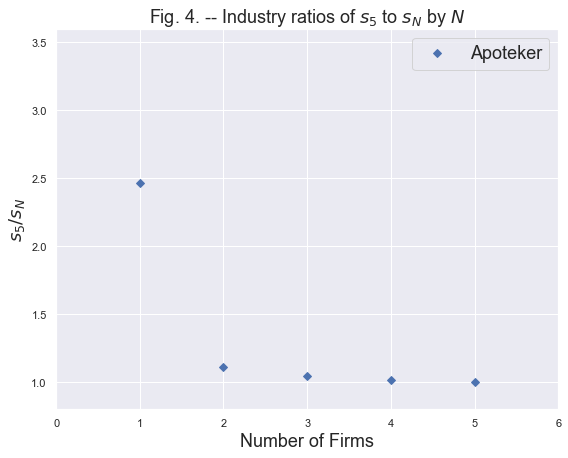

In [454]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.8, 3.6)
plt.title('Fig. 4. -- Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)

#### Q7. Without actually doing it, explain how you would replicate the "Tire Dealers" row of Table 5B.

Use bullet points to outline the procedure.

  - For each column ($s_4 = s_5$, or $s_3 = s_4 = s_5$, etc.), solve for the maximum likelihood solution subject to the constraint.
  - These constraints puts constraints on the parameter values. You will need to write a separate constraint function for each equality in each particular hypothesis to implement these constraints. This constraint function will be passed on to the optimizer.
  - Compare the likelihood of the maximum likelihood solution under the constraint to the likelihood of the maximum likelihood solution under no constraints as per the Likelihood Ratio test statistic: 
  
  $$LR = 2(\ell(\hat \theta) - \ell(\hat \theta_{constrained}) ) \sim \chi^2(d),$$
  
  where $d$ is the number of restrictions in the test (depends on the column of Table 5B).
  - The stars on the numbers are based on the p-values of the LR stats. If the p-value is 5% or less, a star is shown.
  
See p. 997 in the paper for more details.

#### Q8. Approximately how long did you spend on this assignment (including the SQL portions)? (e.g. 7.5 hours)